## DAT 5303 MACHINE LEARNING COURSE CASE: APPRENTICE CHEF ASSIGNMENT 2 

**Made by**: Cihat Burak Zorlu, MSBA-2 
**Date**: 25 January 2021

Importing All necessary Tools and Libraries

In [1]:
import random            as rand                     # random number gen
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
import numpy as np
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

In [2]:
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
file = "./Apprentice_Chef_Dataset.xlsx"

In [3]:
df_chef = pd.read_excel(file)

In [4]:
# checked columns for the dataset
df_chef.columns

Index(['REVENUE', 'CROSS_SELL_SUCCESS', 'NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED'], dtype='object')

### FEATURE ENGINEERING

In [5]:
professional = ["mmm.com", "amex.com", "apple.com", "boeing.com", "caterpillar.com",
    "chevron.com", "cisco.com", "cocacola.com", "disney.com", "dupont.com",
    "exxon.com", "ge.org", "goldmansacs.com", "homedepot.com", "ibm.com",
    "intel.com", "jnj.com", "jpmorgan.com", "mcdonalds.com", "merck.com",
    "microsoft.com", "nike.com", "pfizer.com", "pg.com", "travelers.com",
    "unitedtech.com", "unitedhealth.com", "verizon.com", "visa.com",
    "walmart.com"]

personal = ["gmail.com", "yahoo.com", "protonmail.com"]

junk = ["me.com", "aol.com", "hotmail.com", "live.com", "msn.com", "passport.com"]

# Split by @ and select domains
df_chef['EMAIL_DOMAIN'] = df_chef.EMAIL.str.split('@', expand=True)[1]

# Create email_tue column
df_chef['EMAIL_TYPE'] = '0'

# Populate the Email Type column by if else statements
for index, row in df_chef.iterrows():

    if df_chef.loc[index, 'EMAIL_DOMAIN'] in professional:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'professional'
    elif df_chef.loc[index, 'EMAIL_DOMAIN'] in personal:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'personal'
    elif df_chef.loc[index, 'EMAIL_DOMAIN'] in junk:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'junk'
    elif df_chef.loc[index, 'EMAIL_DOMAIN'] not in professional or df_chef.loc[
            row, 'EMAIL'] not in personal or df.loc[row, 'EMAIL'] not in junk:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'unknown'
    else:
        print("NOT VALID")

email_dummies = pd.get_dummies(df_chef.EMAIL_TYPE, drop_first=True)

df_chef = pd.concat([df_chef, email_dummies], axis=1)

In [6]:
df_chef["EMAIL_TYPE"].head(n = 50 )

0     professional
1     professional
2     professional
3     professional
4     professional
5         personal
6     professional
7     professional
8     professional
9     professional
10        personal
11            junk
12            junk
13            junk
14    professional
15            junk
16        personal
17        personal
18        personal
19    professional
20    professional
21    professional
22        personal
23        personal
24        personal
25        personal
26        personal
27        personal
28        personal
29    professional
30    professional
31        personal
32    professional
33        personal
34        personal
35    professional
36            junk
37            junk
38    professional
39        personal
40    professional
41        personal
42    professional
43    professional
44            junk
45        personal
46        personal
47        personal
48    professional
49    professional
Name: EMAIL_TYPE, dtype: object

Separated the Email by the domain names. Also identified domain names as professional , personal and junk. This gave me the leverage to run regressions with each domain type. Each domain type might have a correlation with our Y - variable, Cross_Sell_Success. 

In [7]:
df_chef.columns

Index(['REVENUE', 'CROSS_SELL_SUCCESS', 'NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED', 'EMAIL_DOMAIN', 'EMAIL_TYPE', 'personal', 'professional'], dtype='object')

In [8]:
#checked names of each individual and tried to come up if there is a significance. 
df_chef.loc[:, "FIRST_NAME"].value_counts().sort_values(ascending = False )

Jon          21
Jeyne        14
Aegon        12
Walder       10
Alyn         10
             ..
Umfred        1
Murenmure     1
Lennocks      1
Wex           1
Delonne       1
Name: FIRST_NAME, Length: 1442, dtype: int64

In [9]:
char = df_chef.loc[:, "NAME"]
df_chef["NUMBER_LETTERS"]  = [len(i) for i in char]

In [10]:
df_chef["NUMBER_LETTERS"]

0        7
1       15
2       14
3       17
4       13
        ..
1941    10
1942    17
1943    12
1944     6
1945    14
Name: NUMBER_LETTERS, Length: 1946, dtype: int64

After further consideration rather than looking at names specifically, I wanted to come up with better solution. So that i have checked how many letters in their name each user has. By looking at the length we can identify who is a better customer in terms of loyalty.

### LOGISTIC REGRESSION
Now that we've finished developing features, we can start the model building process. As a first step, let's see how the explanatory variables correlate to the response variable.

In [11]:
#check correlattions of variables with Y-variable (CROSS_SELL_SUCCESS)
chef_corr = df_chef.corr(method = "pearson")
chef_corr.loc[ : , "CROSS_SELL_SUCCESS"].round(decimals = 2).sort_values(ascending = False)

CROSS_SELL_SUCCESS             1.00
professional                   0.19
NUMBER_LETTERS                 0.18
CANCELLATIONS_BEFORE_NOON      0.16
MOBILE_NUMBER                  0.10
TASTES_AND_PREFERENCES         0.08
REFRIGERATED_LOCKER            0.07
PC_LOGINS                      0.04
CONTACTS_W_CUSTOMER_SERVICE    0.04
PACKAGE_LOCKER                 0.04
MASTER_CLASSES_ATTENDED        0.04
personal                       0.04
AVG_PREP_VID_TIME              0.03
MEDIAN_MEAL_RATING             0.03
EARLY_DELIVERIES               0.02
LARGEST_ORDER_SIZE             0.02
LATE_DELIVERIES                0.01
TOTAL_MEALS_ORDERED            0.01
TOTAL_PHOTOS_VIEWED            0.01
AVG_TIME_PER_SITE_VISIT        0.01
UNIQUE_MEALS_PURCH             0.00
REVENUE                        0.00
PRODUCT_CATEGORIES_VIEWED      0.00
WEEKLY_PLAN                   -0.01
AVG_CLICKS_PER_VISIT          -0.04
CANCELLATIONS_AFTER_NOON      -0.05
MOBILE_LOGINS                 -0.05
Name: CROSS_SELL_SUCCESS, dt

In [12]:
chef_data = df_chef.drop(["CROSS_SELL_SUCCESS"], axis = 1)
chef_target = df_chef.loc[:, "CROSS_SELL_SUCCESS"]

In [13]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chef_target)


# merging training data for statsmodels
chef_train = pd.concat([x_train, y_train], axis = 1)

In [14]:
print(f"""
Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}

Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")


Response Variable Proportions (Training Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64

Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



Split dataset into two groups; Training(75%) and Testing(25%). By that we can make prediction from the model and see how good it is. 

In [15]:
for val in chef_data:
    print(f" {val} + ")

 REVENUE + 
 NAME + 
 EMAIL + 
 FIRST_NAME + 
 FAMILY_NAME + 
 TOTAL_MEALS_ORDERED + 
 UNIQUE_MEALS_PURCH + 
 CONTACTS_W_CUSTOMER_SERVICE + 
 PRODUCT_CATEGORIES_VIEWED + 
 AVG_TIME_PER_SITE_VISIT + 
 MOBILE_NUMBER + 
 CANCELLATIONS_BEFORE_NOON + 
 CANCELLATIONS_AFTER_NOON + 
 TASTES_AND_PREFERENCES + 
 PC_LOGINS + 
 MOBILE_LOGINS + 
 WEEKLY_PLAN + 
 EARLY_DELIVERIES + 
 LATE_DELIVERIES + 
 PACKAGE_LOCKER + 
 REFRIGERATED_LOCKER + 
 AVG_PREP_VID_TIME + 
 LARGEST_ORDER_SIZE + 
 MASTER_CLASSES_ATTENDED + 
 MEDIAN_MEAL_RATING + 
 AVG_CLICKS_PER_VISIT + 
 TOTAL_PHOTOS_VIEWED + 
 EMAIL_DOMAIN + 
 EMAIL_TYPE + 
 personal + 
 professional + 
 NUMBER_LETTERS + 


In [16]:
logit_full = smf.logit( formula = """CROSS_SELL_SUCCESS ~ professional +
CANCELLATIONS_BEFORE_NOON      +
MOBILE_NUMBER                  +
TASTES_AND_PREFERENCES         +
REFRIGERATED_LOCKER            +
MASTER_CLASSES_ATTENDED        +
PACKAGE_LOCKER                 +
CONTACTS_W_CUSTOMER_SERVICE    +
personal                       +
PC_LOGINS                      +
MEDIAN_MEAL_RATING             +
AVG_PREP_VID_TIME              +
LARGEST_ORDER_SIZE             +
EARLY_DELIVERIES               +
LATE_DELIVERIES                +
TOTAL_MEALS_ORDERED            +
TOTAL_PHOTOS_VIEWED            +
AVG_TIME_PER_SITE_VISIT        +
UNIQUE_MEALS_PURCH             +
REVENUE                        +
PRODUCT_CATEGORIES_VIEWED      +
WEEKLY_PLAN                    +
AVG_CLICKS_PER_VISIT           +
CANCELLATIONS_AFTER_NOON       +
MOBILE_LOGINS                  +
NUMBER_LETTERS
 """, data = chef_train)

full_results = logit_full.fit()

full_results.summary()


Optimization terminated successfully.
         Current function value: 0.531740
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1432
Method:                           MLE   Df Model:                           26
Date:                Mon, 25 Jan 2021   Pseudo R-squ.:                  0.1532
Time:                        20:34:04   Log-Likelihood:                -775.81
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 1.438e-44
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.8702      1.391     -3.501      0.000      -7.597      -2.144
professional                    1.9646      0.175     11.211      0.000       1.621       2.308
CANCELLATIONS_BEFORE_NOON       0.2837      0.047      6.015      0.000       0.191       0.376
MOBILE_NUMBER                   0.9001      0.180      5.010      0.000       0.548       1.252
TASTES_AND_PREFERENCES          0.3573      0.138      2.596      0.009       0.087       0.627
REFRIGERATED_LOCKER             0.4968      0.239      2.076      0.038       0.028       0.966
MASTER_CLASSES_ATTENDED         0.1757      0.117      1.500      0.134      -0.054       0.405
PACKAGE_LOCKER                  0.0231      0.149      0.155      0.877      -0.269       0.316
CONTACTS_W_CUSTOMER_SERVICE     0.0525      0.028      1.845      0.065      -0.003       0.108
personal                        1.3279      0.161      8.268      0.000       1.013       1.643
PC_LOGINS                       0.2573      0.109      2.364      0.018       0.044       0.471
MEDIAN_MEAL_RATING              0.1916      0.169      1.133      0.257      -0.140       0.523
AVG_PREP_VID_TIME               0.0046      0.003      1.734      0.083      -0.001       0.010
LARGEST_ORDER_SIZE             -0.0646      0.070     -0.924      0.355      -0.202       0.072
EARLY_DELIVERIES                0.0653      0.028      2.323      0.020       0.010       0.120
LATE_DELIVERIES                 0.0178      0.023      0.781      0.435      -0.027       0.063
TOTAL_MEALS_ORDERED            -0.0005      0.001     -0.309      0.757      -0.003       0.002
TOTAL_PHOTOS_VIEWED            -0.0001      0.000     -0.349      0.727      -0.001       0.001
AVG_TIME_PER_SITE_VISIT     -6.951e-05      0.001     -0.066      0.947      -0.002       0.002
UNIQUE_MEALS_PURCH             -0.0164      0.026     -0.622      0.534      -0.068       0.035
REVENUE                        -0.0002   8.97e-05     -2.182      0.029      -0.000   -1.99e-05
PRODUCT_CATEGORIES_VIEWED      -0.0173      0.021     -0.838      0.402      -0.058       0.023
WEEKLY_PLAN                     0.0059      0.005      1.228      0.219      -0.004       0.015
AVG_CLICKS_PER_VISIT           -0.0097      0.052     -0.187      0.851      -0.111       0.092
CANCELLATIONS_AFTER_NOON       -0.2545      0.145     -1.753      0.080      -0.539       0.030
MOBILE_LOGINS                  -0.1772      0.120     -1.480      0.139      -0.412       0.057
NUMBER_LETTERS                  0.0872      0.013      6.647      0.000       0.061       0.113
===============================================================================================
"""

In [17]:
logit_sig = smf.logit(formula = """CROSS_SELL_SUCCESS ~ professional +
                  CANCELLATIONS_BEFORE_NOON +  MOBILE_NUMBER  + TASTES_AND_PREFERENCES +
                  personal + PC_LOGINS + EARLY_DELIVERIES + NUMBER_LETTERS""", data = chef_train)

logit_sig_1 = logit_sig.fit()
logit_sig_1.summary()

Optimization terminated successfully.
         Current function value: 0.542464
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1450
Method:                           MLE   Df Model:                            8
Date:                Mon, 25 Jan 2021   Pseudo R-squ.:                  0.1361
Time:                        20:34:04   Log-Likelihood:                -791.46
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 2.224e-49
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -4.1804      0.667     -6.266      0.000      -5.488      -2.873
professional                  1.8952      0.171     11.091      0.000       1.560       2.230
CANCELLATIONS_BEFORE_NOON     0.2844      0.046      6.136      0.000       0.194       0.375
MOBILE_NUMBER                 0.8721      0.176      4.958      0.000       0.527       1.217
TASTES_AND_PREFERENCES        0.3796      0.135      2.810      0.005       0.115       0.644
personal                      1.3081      0.157      8.342      0.000       1.001       1.615
PC_LOGINS                     0.2363      0.107      2.214      0.027       0.027       0.445
EARLY_DELIVERIES              0.0625      0.028      2.268      0.023       0.009       0.117
NUMBER_LETTERS                0.0836      0.013      6.495      0.000       0.058       0.109
=============================================================================================
"""

Based on the output above, I have removed all variables which are insignificant in terms on their p-values. Once finished, check the p-values again to ensure that all variables are still significant.

In [18]:

candidate_dict = {
 'logit_full'   : [ "professional" ,
"CANCELLATIONS_BEFORE_NOON"      ,
"MOBILE_NUMBER"                  ,
"TASTES_AND_PREFERENCES"         ,
"REFRIGERATED_LOCKER"            ,
"MASTER_CLASSES_ATTENDED"        ,
"PACKAGE_LOCKER"                 ,
"CONTACTS_W_CUSTOMER_SERVICE"    ,
"personal"                       ,
"PC_LOGINS"                      ,
"MEDIAN_MEAL_RATING"             ,
"AVG_PREP_VID_TIME"              ,
"LARGEST_ORDER_SIZE"             ,
"EARLY_DELIVERIES"               ,
"LATE_DELIVERIES"                ,
"TOTAL_MEALS_ORDERED"            ,
"TOTAL_PHOTOS_VIEWED"            ,
"AVG_TIME_PER_SITE_VISIT"        ,
"UNIQUE_MEALS_PURCH"             ,
"REVENUE"                        ,
"PRODUCT_CATEGORIES_VIEWED"      ,
"WEEKLY_PLAN"                    ,
"AVG_CLICKS_PER_VISIT"           ,
"CANCELLATIONS_AFTER_NOON"       ,
"MOBILE_LOGINS"                  , 
"NUMBER_LETTERS"],
 'logit_sig'    : ["professional" ,
                  "CANCELLATIONS_BEFORE_NOON" , "MOBILE_NUMBER"  ,
                  "personal" ,"PC_LOGINS" ,"EARLY_DELIVERIES", "TASTES_AND_PREFERENCES", "NUMBER_LETTERS"], 
 'logit_sig_2'  : ["professional" ,
                  "CANCELLATIONS_BEFORE_NOON" , "MOBILE_NUMBER"  ,
                  "personal", "NUMBER_LETTERS"]}

Created a dictionary, to use in my following models. 

#### LOGISTIC REGRESSION RESULTS 

In [19]:
chef_data   =  df_chef.loc[ : , candidate_dict["logit_sig_2"]]
chef_target =  df_chef.loc[ : , "CROSS_SELL_SUCCESS"]


# This is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chef_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219) # start somewhere and fit the data until they converge


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))
print('AUC Log_reg:', roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

logreg_auc_score   = roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4)



Training ACCURACY: 0.7313
Testing  ACCURACY: 0.7228
AUC Log_reg: 0.6164


In [20]:
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 50
False Positives: 106
False Negatives: 29
True Positives : 302



### CLASSIFICATION TREE (CART MODELS)

Tree models are very useful in classification problems as they output interesting tools such as tree plots and feature importance. 

In [21]:
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

#### FULL TREE

As an initial start point, I have modeled a Decision Tree which is full in terms of variables.

In [22]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                    y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                    y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.8088
Full Tree Testing ACCURACY : 0.6899
Full Tree AUC Score: 0.6482


In [23]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 83
False Positives: 73
False Negatives: 78
True Positives : 253



#### PRUNED TREE

After initiating my regression with full tree, I have pruned my model to have better score and better predictions for further analysis. Pruning the tree allowed me to have deeper analysis and better insights with my Confusion matrix. 

In [24]:
# INSTANTIATING a classification tree object
tree_pruned = DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
tree_pruned_fit = tree_pruned.fit(x_train, y_train)


# PREDICTING on new data
p_tree_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = p_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = p_tree_pred).round(4) # auc

Training ACCURACY: 0.7471
Testing  ACCURACY: 0.7659
AUC Score        : 0.7075


In [25]:
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = p_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}""")


True Negatives : 85
False Positives: 71
False Negatives: 43
True Positives : 288


<ipython-input-21-39005325f4a5>:60: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


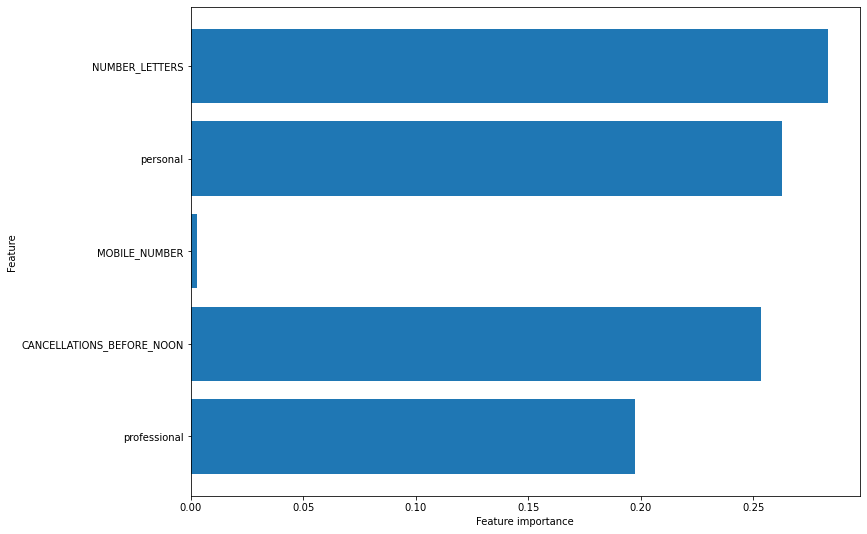

In [26]:
plot_feature_importances(tree_pruned_fit,
                         train  = x_train,
                         export = False)

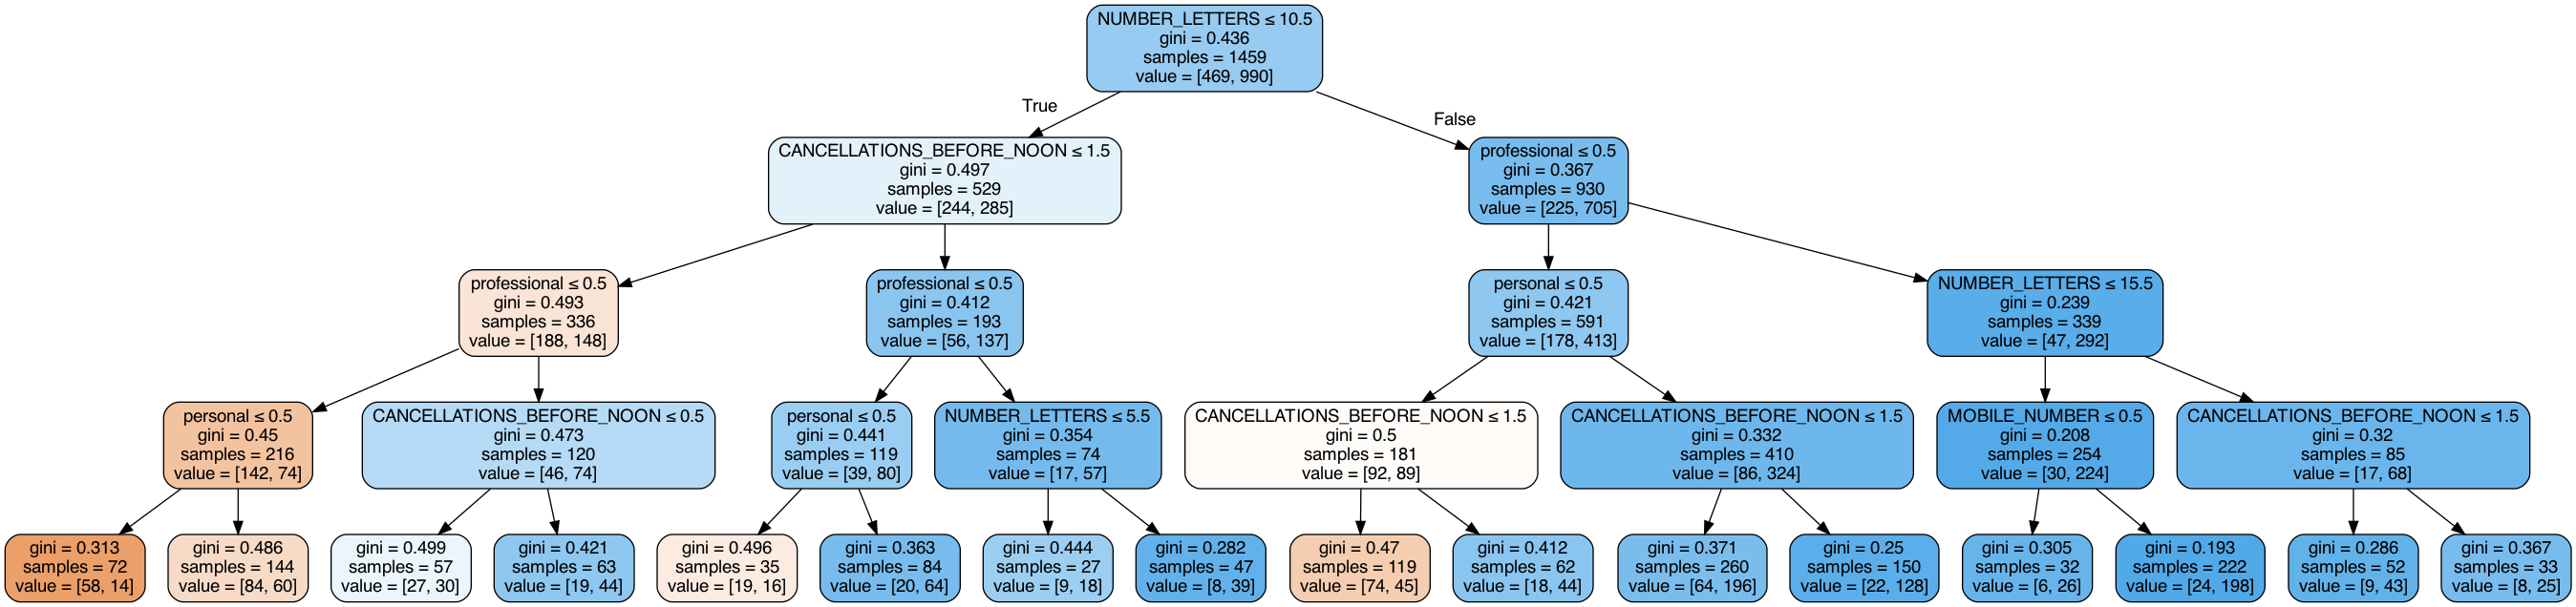

In [27]:
# calling display_tree
display_tree(tree       = tree_pruned_fit,
             feature_df = x_train)

In [28]:
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree     {full_tree_auc_score}         {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree   {pruned_tree_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# sending model results to Excel
model_performance.to_excel('./classification_model_performance.xlsx',
                           index = False)


Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      0.6164         (50, 106, 29, 302)
Full Tree     0.6482         (83, 73, 78, 253)
Pruned Tree   0.7075         (85, 71, 43, 288)



### HYPERPARAMETER TUNING

We could manually analyze each combination of hyperparameter values one by one, however to make this process much faster we use RandomizedSearchCV from scikit-learn to autonomize this such burden.

In [29]:
def display_tree(tree, feature_df, height = 500, width = 800, export = False):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    export     : bool, defalut False
        whether or not to export the tree as a .png file
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width,
                unconfined = True)


    return img

#### HYPERPARAMETER TUNING WITH LOGISTIC REGRESSION

In [30]:
C_space          = np.arange(0.1, 5.0, 0.1)
warm_start_space = [True, False]
solver_space     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space,
              'solver'     : solver_space}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000)


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

Tuned Parameters  : {'warm_start': True, 'solver': 'newton-cg', 'C': 3.9000000000000004}
Tuned CV AUC      : 0.6411


In [31]:
lr_tuned_cv.best_estimator_

LogisticRegression(C=3.9000000000000004, max_iter=1000, random_state=219,
                   solver='newton-cg', warm_start=True)

In [32]:
lr_tuned = lr_tuned_cv.best_estimator_


# FIT step is not needed


# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                  y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

Training ACCURACY: 0.7368
Testing  ACCURACY: 0.7248
AUC Score        : 0.623


In [33]:
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")


True Negatives : 53
False Positives: 103
False Negatives: 31
True Positives : 300



In [34]:
lr_train_acc = lr_tuned.score(x_train, y_train).round(4)
lr_test_acc  = lr_tuned.score(x_test, y_test).round(4)
lr_auc       = roc_auc_score(y_true  = y_test,
                             y_score = lr_tuned_pred).round(4)

# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'             : 'Tuned LR',
                          'Training Accuracy'  : lr_train_acc,
                          'Testing Accuracy'   : lr_test_acc,
                          'AUC Score'          : lr_auc,
                          'Confusion Matrix'   : (lr_tuned_tn,
                                                  lr_tuned_fp,
                                                  lr_tuned_fn,
                                                  lr_tuned_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6164,0.7313,0.7228,"(50, 106, 29, 302)"
1,Full Tree,0.6482,0.8088,0.6899,"(83, 73, 78, 253)"
2,Pruned Tree,0.7075,0.7471,0.7659,"(85, 71, 43, 288)"
3,Tuned LR,0.6230,0.7368,0.7248,"(53, 103, 31, 300)"


#### HYPERPARAMETER TUNING WITH CART MODELS

In [35]:
# declaring a hyperparameter space
criterion_space = ['gini', 'entropy']
splitter_space  = ['best', 'random']
depth_space     = pd.np.arange(1, 25, 1)
leaf_space      = pd.np.arange(1, 100, 1)


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_space,
              'splitter'         : splitter_space,
              'max_depth'        : depth_space,
              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)

# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 250, # changed for the sake of time
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

<ipython-input-35-5650c54a1edd>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  depth_space     = pd.np.arange(1, 25, 1)
<ipython-input-35-5650c54a1edd>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space      = pd.np.arange(1, 100, 1)


Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 17, 'max_depth': 5, 'criterion': 'entropy'}
Tuned Training AUC: 0.6769


In [36]:
tree_tuned = tuned_tree_cv.best_estimator_


# FIT step is not needed


# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)

# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.756
Testing  ACCURACY: 0.7741
AUC Score        : 0.7169


In [37]:
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 87
False Positives: 69
False Negatives: 41
True Positives : 290



In [38]:
# declaring model performance objects
tree_train_acc = tree_tuned.score(x_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(x_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,
                              y_score = tree_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned Tree',
                           'Training Accuracy' : tree_train_acc,
                           'Testing Accuracy'  : tree_test_acc,
                           'AUC Score'         : tree_auc,
                           'Confusion Matrix'  : (tuned_tree_tn,
                                                  tuned_tree_fp,
                                                  tuned_tree_fn,
                                                  tuned_tree_tp)},
                           ignore_index = True)
# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6164,0.7313,0.7228,"(50, 106, 29, 302)"
1,Full Tree,0.6482,0.8088,0.6899,"(83, 73, 78, 253)"
2,Pruned Tree,0.7075,0.7471,0.7659,"(85, 71, 43, 288)"
3,Tuned LR,0.6230,0.7368,0.7248,"(53, 103, 31, 300)"
4,Tuned Tree,0.7169,0.7560,0.7741,"(87, 69, 41, 290)"


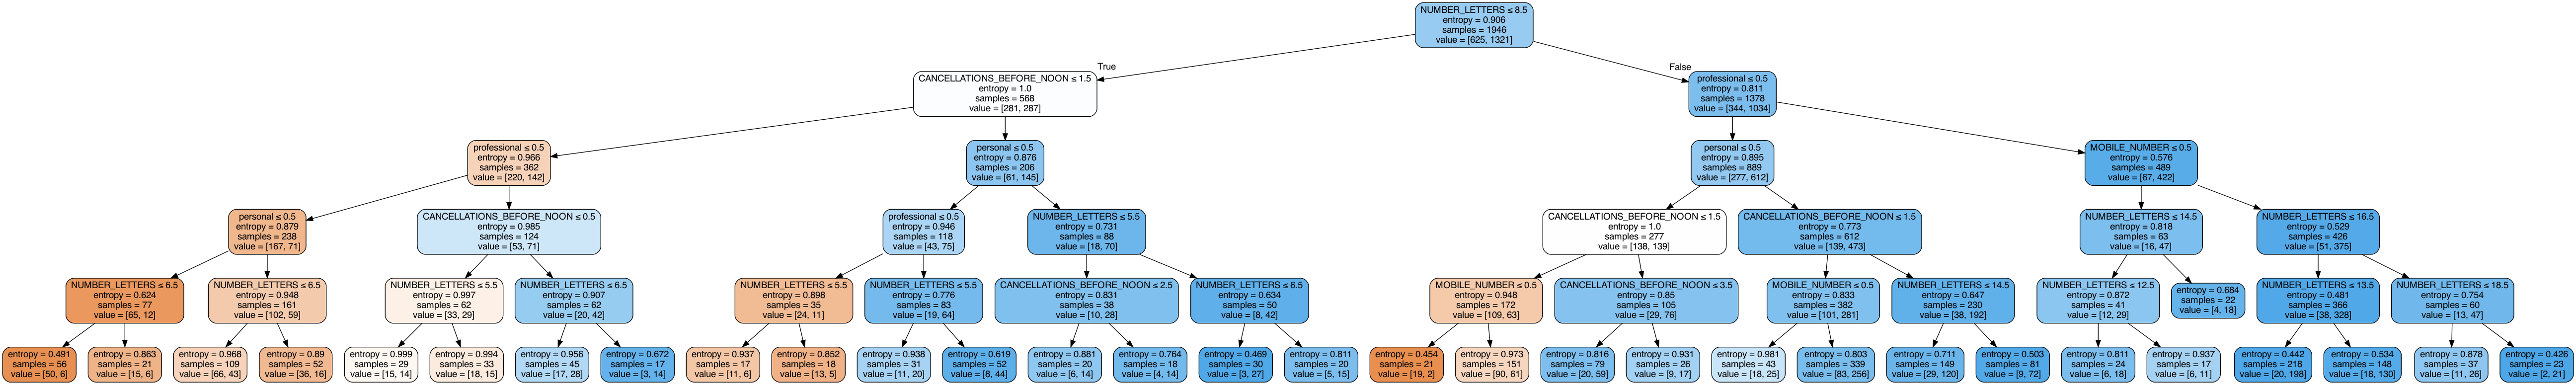

In [39]:
display_tree(tree = tree_tuned,
             feature_df = chef_data,
             height = 1500,
             width  = 750)

In [40]:
model_performance.to_excel('./classification_model_performance.xlsx',
                           index = False)

### RANDOM FOREST

In [41]:
rf_default = RandomForestClassifier(n_estimators     = 100, #number of classification trees
                                    criterion        = "gini",
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

In [42]:
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8088
Testing  ACCURACY: 0.7248
AUC Score        : 0.6586


In [43]:
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 74
False Positives: 82
False Negatives: 52
True Positives : 279



In [44]:
rf_train_acc = rf_default_fit.score(x_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(x_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Full)',
                           'Training Accuracy'  : rf_train_acc,
                           'Testing Accuracy'   : rf_test_acc,
                           'AUC Score'          : rf_auc,
                           'Confusion Matrix'   : (rf_tn,
                                                   rf_fp,
                                                   rf_fn,
                                                   rf_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6164,0.7313,0.7228,"(50, 106, 29, 302)"
1,Full Tree,0.6482,0.8088,0.6899,"(83, 73, 78, 253)"
2,Pruned Tree,0.7075,0.7471,0.7659,"(85, 71, 43, 288)"
3,Tuned LR,0.6230,0.7368,0.7248,"(53, 103, 31, 300)"
4,Tuned Tree,0.7169,0.7560,0.7741,"(87, 69, 41, 290)"
5,Random Forest (Full),0.6586,0.8088,0.7248,"(74, 82, 52, 279)"


In [45]:
# FITTING the training data
#rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
#rf_default_fit_pred = rf_default_fit.predict(x_test)


# declaring a hyperparameter space
#estimator_space  = pd.np.arange(100, 1100, 250)
#leaf_space       = pd.np.arange(1, 31, 10)
#criterion_space  = ['gini', 'entropy']
#bootstrap_space  = [True, False]
#warm_start_space = [True, False]


# creating a hyperparameter grid
#param_grid = {'n_estimators'     : estimator_space,
#              'min_samples_leaf' : leaf_space,
#              'criterion'        : criterion_space,
#              'bootstrap'        : bootstrap_space,
#              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
#forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
#forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                               param_distributions = param_grid,
#                               cv         = 3,
#                               n_iter     = 1000,
#                              scoring    = make_scorer(roc_auc_score,
#                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#forest_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", forest_cv.best_params_)
#print("Tuned Training AUC:", forest_cv.best_score_.round(4))

In [46]:
forest_tuned = RandomForestClassifier(min_samples_leaf=11, n_estimators=850, random_state=219,
                       warm_start=True)


# FITTING the model object
forest_tuned_fit = forest_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.7574
Forest Tuned Testing  ACCURACY: 0.7721
Forest Tuned AUC Score        : 0.7052


In [47]:
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")


True Negatives : 81
False Positives: 75
False Negatives: 36
True Positives : 295



In [48]:
tuned_rf_train_acc = forest_tuned_fit.score(x_train, y_train).round(4)
tuned_rf_test_acc  = forest_tuned_fit.score(x_test, y_test).round(4)
tuned_rf_auc       = roc_auc_score(y_true  = y_test,
                                   y_score = forest_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Tuned Random Forest (Full)',
                           'Training Accuracy'  : tuned_rf_train_acc,
                           'Testing Accuracy'   : tuned_rf_test_acc,
                           'AUC Score'          : tuned_rf_auc,
                           'Confusion Matrix'   : (tuned_rf_tn,
                                                   tuned_rf_fp,
                                                   tuned_rf_fn,
                                                   tuned_rf_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6164,0.7313,0.7228,"(50, 106, 29, 302)"
1,Full Tree,0.6482,0.8088,0.6899,"(83, 73, 78, 253)"
2,Pruned Tree,0.7075,0.7471,0.7659,"(85, 71, 43, 288)"
3,Tuned LR,0.6230,0.7368,0.7248,"(53, 103, 31, 300)"
4,Tuned Tree,0.7169,0.7560,0.7741,"(87, 69, 41, 290)"
5,Random Forest (Full),0.6586,0.8088,0.7248,"(74, 82, 52, 279)"
6,Tuned Random Forest (Full),0.7052,0.7574,0.7721,"(81, 75, 36, 295)"


In [49]:
full_gbm_default = GradientBoostingClassifier(loss          = "deviance",
                                              learning_rate = 0.06,
                                              n_estimators  = 100,
                                              criterion     = "friedman_mse",
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_default_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_default_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4))

Training ACCURACY: 0.7567
Testing ACCURACY : 0.7433
AUC Score        : 0.6654


In [50]:
# unpacking the confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_default_tn}
False Positives: {gbm_default_fp}
False Negatives: {gbm_default_fn}
True Positives : {gbm_default_tp}
""")


True Negatives : 70
False Positives: 86
False Negatives: 39
True Positives : 292



In [51]:
gbm_train_acc = full_gbm_default_fit.score(x_train, y_train).round(4)
gbm_test_acc  = full_gbm_default_fit.score(x_test, y_test).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test,
                              y_score = full_gbm_default_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'       : 'GBM (Full)',
                          'Training Accuracy' : gbm_train_acc,
                          'Testing Accuracy'  : gbm_test_acc,
                          'AUC Score'         : gbm_auc,
                          'Confusion Matrix'  : (gbm_default_tn,
                                                 gbm_default_fp,
                                                 gbm_default_fn,
                                                 gbm_default_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6164,0.7313,0.7228,"(50, 106, 29, 302)"
1,Full Tree,0.6482,0.8088,0.6899,"(83, 73, 78, 253)"
2,Pruned Tree,0.7075,0.7471,0.7659,"(85, 71, 43, 288)"
3,Tuned LR,0.6230,0.7368,0.7248,"(53, 103, 31, 300)"
4,Tuned Tree,0.7169,0.7560,0.7741,"(87, 69, 41, 290)"
5,Random Forest (Full),0.6586,0.8088,0.7248,"(74, 82, 52, 279)"
6,Tuned Random Forest (Full),0.7052,0.7574,0.7721,"(81, 75, 36, 295)"
7,GBM (Full),0.6654,0.7567,0.7433,"(70, 86, 39, 292)"


In [52]:
# declaring a hyperparameter space
#learn_space        = pd.np.arange(0.1, 2.0, 0.2)
#estimator_space    = pd.np.arange(100, 200, 25)
#depth_space        = pd.np.arange(1, 20, 2)
#min_samples_leaf   = pd.np.arange(5, 30, 2)
#warm_start_space   = [True, False]

# creating a hyperparameter grid
#param_grid = {'learning_rate' : learn_space,
#              'max_depth'     : depth_space,
#              'n_estimators'  : estimator_space,
#              'warm_start'     : warm_start_space,
#              'min_samples_leaf' : min_samples_leaf}


# INSTANTIATING the model object without hyperparameters
#full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
#full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                           param_distributions = param_grid,
#                           cv                  = 3,
#                           n_iter              = 500,
#                           random_state        = 219,
#                           scoring             = make_scorer(roc_auc_score,
#                                                 needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#full_gbm_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", full_gbm_cv.best_params_)
#print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

I have hashtagged out the Gradient Boosted Model model to run the script faster. Otherwise, it would run more than 10 minutes. 

In [53]:
gbm_tuned = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5000000000000001, loss='deviance',
                           max_depth=8, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=11, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=219, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=True)


# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

Training ACCURACY: 0.8081
Testing  ACCURACY: 0.7331
AUC Score        : 0.6698


In [54]:
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")


True Negatives : 77
False Positives: 79
False Negatives: 51
True Positives : 280



In [55]:
model_performance.sort_values(by = 'AUC Score',
                              ascending = False)

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
4,Tuned Tree,0.7169,0.7560,0.7741,"(87, 69, 41, 290)"
2,Pruned Tree,0.7075,0.7471,0.7659,"(85, 71, 43, 288)"
6,Tuned Random Forest (Full),0.7052,0.7574,0.7721,"(81, 75, 36, 295)"
7,GBM (Full),0.6654,0.7567,0.7433,"(70, 86, 39, 292)"
5,Random Forest (Full),0.6586,0.8088,0.7248,"(74, 82, 52, 279)"
1,Full Tree,0.6482,0.8088,0.6899,"(83, 73, 78, 253)"
3,Tuned LR,0.6230,0.7368,0.7248,"(53, 103, 31, 300)"
0,Logistic,0.6164,0.7313,0.7228,"(50, 106, 29, 302)"


### CONCLUSION

To sum up, after evaluating each and every model, finally I have decided to use Tuned Tree model. Tuned Tree model has a Training and testing gap of less than 0.05 with 0.02. This states that we can make predictions very accurate with our training data. 

In this specific case problem, we need to identify the importance of variables which has an impact on the success of cross sell performance. Cross-selling identifies products that satisfy additional, complementary needs that are unfulfilled by the original item. In this case, from my perspective one of the most important metrics from my model is the False Positive Rate. Because F/P rate states that, model predicted an user to buy a product however in reality they don't buy the product. This results in bad estimations in our revenue expectations. Tuned Tree Model has the least number of False Positive rate which makes it again a better model for this analysis. 

Finally, AUC (Area Under Curve) of ROC is another important metric for my analysis. The AUC is an estimate of the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance. For this reason, the AUC is widely thought to be a better measure than a classification error rate. So that higher the AUC is better the model. Simply AUC calculates the area under the ROC, by looking at the change of F/P and T/P throughout a time. 

For this case I would definitely go with **Tuned Tree Model**. 